<a href="https://colab.research.google.com/github/hannape/CNN-second/blob/master/split_recording.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Dzielenie na próbki, zapis

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

!pip install audiosegment
!pip install librosa
!pip install pydub
!pip install webrtcvad
from scipy.io import wavfile
from random import choice
import librosa
from pydub import AudioSegment
from pydub.utils import make_chunks
import math
import audiosegment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

source = "drive/My Drive/nagrania_probne/"
source_out = "drive/My Drive/nagrania_probne/balanced/"
nazwa = "1swierszcze_nakladki_BUK4_20160925_204604"
name = "1swierszcze_nakladki_BUK4_20160925_204604.wav"
name_txt = "1swierszcze_nakladki_BUK4_20160925_204604dot.txt"
name_out = "_all"

In [0]:
#### Parametry ####
chunk_length_ms = 500
chunk_overlap = 150
bit_rate = 16
###################

fs, data = wavfile.read(source + name)

myaudio = audiosegment.from_file(source + name)
channel_count = myaudio.channels    #Get channels
sample_width = myaudio.sample_width #Get sample width
duration_in_ms = len(myaudio) #Length of audio in ms
sample_rate = myaudio.frame_rate
nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)


########## Odczyt labeli z csv, wyczyszczenie zaznaczonych trzasków (t, ?)

y_read = pd.read_csv(source + name_txt,  header=None, sep = "\t")
y_read.columns = ["start", "end", "bird"]
y_read_cleanedA = y_read[y_read['bird']!= 't']  # deleted 't'
y_read_cleaned = y_read_cleanedA[y_read_cleanedA['bird']!= 't?'] # deleted 't?'
print(y_read_cleaned)
y_read = y_read_cleaned

In [0]:
#wav_file_size = (sample_rate * bit_rate * channel_count * duration_in_ms / 1000) / 8

#### Parametry ####
plot = 0               # czy wyrysowywać głosy wszystkie
minimal_duration = 4   # minimalny czas trwania głosu w ms, b zakwalifikowac chunka jako hasbird
f_min = 4000           # minimalna częstotliwość analizowana ze spektro
f_max = 9500           # maxymala częstotliwość analizowana ze spektro
###################


########## Wyszukanie pozytywnych fragmentów - fragmentów zawierający głos, ilość takich ramek

image_positive = []
description_positive = []
sum_birds=0
has_bird = 1

for i in range(0,math.floor(nr_of_chunks)): 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  x = range(frame_start,frame_end)
  
  for j in y_read.index.tolist():
    bird_start = int(round(y_read.start[j]*1000))
    bird_end = int(round(y_read.end[j]*1000))
    y = range(bird_start,bird_end)
    
    intersect_start = max(x[0], y[0])
    intersect_end = min(x[-1], y[-1])+1
    range1 = (range(intersect_start, intersect_end))
    
    if len(range1)> minimal_duration: 
      sum_birds = sum_birds+1
      
      ## reprezentacja 1 - spektrogram
      freqs, times, amplitudes = frame.spectrogram(window_length_samples=512, overlap=0.7)
      amplitudes = amplitudes[(freqs >= f_min) & (freqs <= f_max)]
      freqs = freqs[(freqs >= f_min) & (freqs <= f_max)]
      
      image_positive.append(amplitudes)
      description_positive.append([i, frame_start, frame_end, intersect_start, intersect_end, bird_start, bird_end, has_bird, 0, 0])
      
      if plot ==1:
      # Plot
        amplitudes = 10 * np.log10(amplitudes + 1e-9)
        plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
        plt.xlabel("Time in Seconds")
        plt.ylabel("Frequency in Hz")
        plt.show()
    
#print(sum_birds)
#print(np.shape(description_positive))
#print(np.shape(image_positive))
#print(i,frame_start, frame_end)

In [0]:
########## Usunięcie duplikatów, zakładamy że nie więcej niż 2 głosy w ramce

labels = ['Chunk_nr', 'Chunk_start', 'Chunk_end', 'Call_start_chunk','Call_end_chunk','Call_start','Call_end','Has_bird','2nd_call_start','2nd_call_end']
description_pd = pd.DataFrame.from_records(description_positive, columns=labels)   # na lepszy format

duplic = description_pd[description_pd.duplicated(subset='Chunk_nr',keep=False)]   # wypisanie duplikujących sie ramek (ale z innym glosem zawartym)
duplic_index = duplic.drop_duplicates(subset='Chunk_nr',keep='first')['Chunk_nr'].index.tolist() 
#print(duplic)
#print(duplic_index)

df = description_pd.drop_duplicates(subset='Chunk_nr',keep='first')  # usuwamy drugie duplikaty z listy
for i in duplic_index:
  df['2nd_call_start'][i]= description_pd['Call_start'][i+1]   # dopisujemy drugi głos do ramki
  df['2nd_call_end'][i]= description_pd['Call_end'][i+1]

########## Macierz wyjściowa obrazów i opisów, same ptaki
  
description_positive_no_duplic = df  
image_positive_no_duplic = np.delete(image_positive, (duplic_index), axis=0)
print(np.shape(image_positive_no_duplic))
print((description_positive_no_duplic))

In [0]:
########## Indexy pustych ramek
random.seed(667)
sum_birds = np.shape(image_positive_no_duplic)[0]  # bez powtórzeń już

birds_chunks = description_positive_no_duplic['Chunk_nr'].tolist()
range_nonbirds = [i for i in range(0, math.floor(nr_of_chunks)) if i not in birds_chunks]
nobirds_chunks = random.sample(range_nonbirds, sum_birds)  # dobieramy tyle ramek bez ptaków, co mamy z ptakami
#print(nobirds_chunks)

In [0]:
########## Utworzenie macierzy z ramkami bez ptaków
image_negative = []
description_negative = []

for i in nobirds_chunks: 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  #print(frame_start,frame_end)
  x = range(frame_start,frame_end)

  ## reprezentacja 1 - spektrogram
  freqs, times, amplitudes = frame.spectrogram(window_length_samples=512, overlap=0.7)
  amplitudes = amplitudes[(freqs >= f_min) & (freqs <= f_max)]
  freqs = freqs[(freqs >= f_min) & (freqs <= f_max)]
      
  image_negative.append(amplitudes)
  description_negative.append([i, frame_start, frame_end, 0, 0, 0, 0, 0, 0, 0])
        
#print(description_negative[:3])
#print(np.shape(description_negative))
#print(np.shape(image_negative))  

In [0]:
########## Złożenie dwóch macierzy i zapis
description_negative_pd = pd.DataFrame.from_records(description_negative, columns=labels)

final_dataset = np.concatenate([image_positive_no_duplic, np.array(image_negative)])
final_description = pd.concat([description_positive_no_duplic,description_negative_pd])

np.save((source_out + nazwa + 'balanced_dataset' ),final_dataset)
np.savez((source_out + nazwa + 'all' ),final_dataset=final_dataset,final_description=final_description, freqs=freqs, times= times, nobirds_chunks=nobirds_chunks)

Chunk_nr               692
Chunk_start         242200
Chunk_end           242700
Call_start_chunk    242251
Call_end_chunk      242273
Call_start          242251
Call_end            242273
Has_bird                 1
2nd_call_start      242618
2nd_call_end        242633
Name: 19, dtype: int64


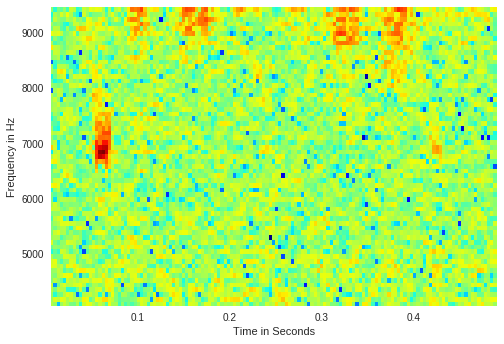

Chunk_nr              1202
Chunk_start         420700
Chunk_end           421200
Call_start_chunk         0
Call_end_chunk           0
Call_start               0
Call_end                 0
Has_bird                 0
2nd_call_start           0
2nd_call_end             0
Name: 121, dtype: int64


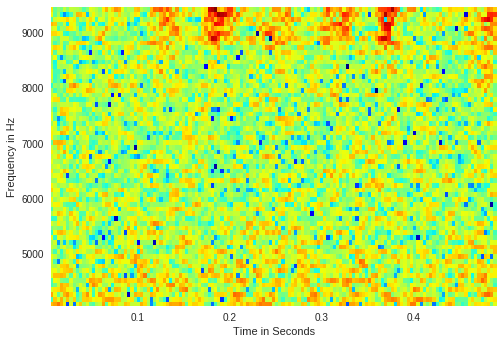

In [350]:
########## Przykład, z ptakiem i bez ptaka
for i in (18, 245):  
  print(final_description.iloc[i])  
  amplitudes = 10 * np.log10(final_dataset[i] + 1e-9)
  plt.pcolormesh(times, freqs, amplitudes, cmap="jet")
  plt.xlabel("Time in Seconds")
  plt.ylabel("Frequency in Hz")
  plt.show()

In [0]:
########## Przykład jak ładować dane

dane1 = np.load(source_out + nazwa + 'balanced_dataset.npy')
opisy1 = np.load(source_out + nazwa + nazwa_out + '.npz' )
fre = opisy1['freqs']
#print(opisy1.files)
#print(fre)


In [0]:
# pięć różnych reprezentacji

# 1. zwykłe spektro
# 2. multitaper